## Import packages

In [1]:
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import levene, bartlett
from scipy.stats import mannwhitneyu
import pandas as pd
from scipy.stats import ttest_ind
import Levenshtein
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr
import matplotlib.style as style

In [2]:
style.use('seaborn-v0_8-whitegrid')
def ConhenD(group1, group2):
    mean1 = np.mean(group1)
    mean2 = np.mean(group2)
    std1 = np.std(group1, ddof=1)  # 使用Bessel校正
    std2 = np.std(group2, ddof=1)

    # 计算Cohen's d
    pooled_std = np.sqrt(((len(group1)-1) * std1**2 + (len(group2)-1) * std2**2) / (len(group1) + len(group2) - 2))
    cohen_d = (mean1 - mean2) / pooled_std

    print("Cohen's d:", cohen_d)


def diff_analysis(vector1, vector2):
    # 进行Levene方差比较检验
    statistic, p_value_var = levene(vector1, vector2)

    print("Levene's test statistic for variance comparison:", statistic)
    print("P-value for variance comparison:", p_value_var)
    equal_var = None
    # 根据方差比较结果选择t检验方法
    if p_value_var < 0.05:
        ttest_method = 'Mann-Whitney U'
        equal_var = False  # 使用 Mann-Whitney U
    else:
        ttest_method = 'Student'
        equal_var = True   # 使用Student's t-test
    statistic = None
    p_value = None
    # 进行t检验
    if equal_var:
        statistic, p_value = ttest_ind(vector1, vector2, equal_var=equal_var)
    else:
        statistic, p_value = mannwhitneyu(vector1, vector2)
    print(f"The statistical value of t test is STA: {statistic} and p_value: {p_value}")
    alpha = 0.05
    if p_value < alpha:
        print(f"Reject the null hypothesis using {ttest_method}'s t-test: There is a significant difference between the two vectors.")
    else:
        print(f"Fail to reject the null hypothesis using {ttest_method}'s t-test: There is no significant difference between the two vectors.")

def draw_kde_BLOCK(array1, array2, array3, array4, name = "default"):
    # 创建一个包含两个子图的大图
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # 绘制左边的KDE图
    sns.kdeplot(array1, label='Control group', ax=axes[0], fill=True)
    sns.kdeplot(array2, label='Experiment group', ax=axes[0], fill=True)
    diff_analysis(array1, array2)
        
    axes[0].set_xlabel('Score', fontsize = 16)
    axes[0].set_ylabel('Density', fontsize = 16)
    axes[0].set_title('Important landmarks', fontsize = 20)
    axes[0].legend()
    axes[0].set_xlim(-1, 3)
    # 绘制右边的KDE图
    sns.kdeplot(array3, label='Control group', ax=axes[1], fill=True)
    sns.kdeplot(array4, label='Experiment group', ax=axes[1], fill=True)
    axes[1].set_xlabel('Score', fontsize = 16)
    axes[1].set_ylabel('Density', fontsize = 16)
    axes[1].set_title('Un-important landmarks', fontsize = 20)
    axes[1].legend()
    axes[1].set_xlim(-1, 3)
    diff_analysis(array3, array4)

    # 调整子图之间的间距
    plt.tight_layout()
    
    plt.savefig(name + ".png")
    # 显示图形
    plt.show()
    
def array_variable_diff(LIKE, REMEMBER, LOCATION, ORIENTATION, name = "default"):
    # 正态性检验（Shapiro-Wilk测试）
    def perform_shapiro_test(data):
        stat, p = stats.shapiro(data)
        return p

    # 方差齐性检验（Levene测试）
    def perform_levene_test(*data_arrays):
        stat, p = stats.levene(*data_arrays)
        return p

    # 多因素ANOVA
    def perform_anova(*data_arrays):
        f_statistic, p_value = f_oneway(*data_arrays)
        return p_value

    # 执行正态性检验
    p_like = perform_shapiro_test(LIKE)
    p_remember = perform_shapiro_test(REMEMBER)
    p_location = perform_shapiro_test(LOCATION)
    p_orientation = perform_shapiro_test(ORIENTATION)

    print("正态性检验结果:")
    print("喜好程度:", p_like)
    print("辅助记忆区域:", p_remember)
    print("辅助定位:", p_location)
    print("辅助认知朝向:", p_orientation)
    # 执行方差齐性检验
    p_levene = perform_levene_test(LIKE, REMEMBER, LOCATION, ORIENTATION)

    print("\n方差齐性检验结果:")
    print("Levene检验p值:", p_levene)

    # 执行多因素ANOVA
    p_anova = perform_anova(LIKE, REMEMBER, LOCATION, ORIENTATION)

    print("\n多因素ANOVA结果:")
    print("ANOVA p值:", p_anova)

    # 判断是否进行事后分析
    if p_anova < 0.05:
        print("\n存在显著差异，可以进行事后分析。")
    else:
        print("\n各方面评分没有显著差异。")


    # 将数据组合成一个单独的数组，以便进行事后分析
    all_data = np.concatenate([LIKE, REMEMBER, LOCATION, ORIENTATION])
    labels = ['PREFERENCE'] * len(LIKE) + ['MEMORY'] * len(REMEMBER) + ['LOCATING'] * len(LOCATION) + ['ORIENTATION'] * len(ORIENTATION)

    # 进行Tukey HSD事后分析
    result = pairwise_tukeyhsd(all_data, labels, 0.05)
    print(result._results_table)
    
    result.plot_simultaneous()
    plt.title(name)
    plt.xlabel("Score")
    
    plt.show()

    # 计算平均分数
    average_like = sum(LIKE) / len(LIKE)
    average_remember = sum(REMEMBER) / len(REMEMBER)
    average_location = sum(LOCATION) / len(LOCATION)
    average_orientation = sum(ORIENTATION) / len(ORIENTATION)

    # 构建一个字典，方便后续处理
    average_scores = {
        "喜好程度": average_like,
        "辅助记忆区域": average_remember,
        "辅助定位": average_location,
        "辅助认知朝向": average_orientation
    }

    # 找出平均分数最高的方面
    max_score_aspect = max(average_scores, key=average_scores.get)

    print("平均分数:")
    for aspect, score in average_scores.items():
        print(f"{aspect}: {score:.2f}")

    print(f"\n用户辅助最大的方面是：{max_score_aspect}")

    
def n_array_variable_diff(COLOR, LABEL, LANDMARK, name = "default", savename = "default.png"):
    # 正态性检验（Shapiro-Wilk测试）
    def perform_shapiro_test(data):
        stat, p = stats.shapiro(data)
        return p

    # 方差齐性检验（Levene测试）
    def perform_levene_test(*data_arrays):
        stat, p = stats.levene(*data_arrays)
        return p

    # 多因素ANOVA
    def perform_anova(*data_arrays):
        f_statistic, p_value = f_oneway(*data_arrays)
        return p_value

    # 执行正态性检验
    p_color = perform_shapiro_test(COLOR)
    p_label = perform_shapiro_test(LABEL)
    p_landmark = perform_shapiro_test(LANDMARK)

    print("正态性检验结果:")
    print("COLOR:", p_color)
    print("LABEL:", p_label)
    print("LANDMARK:", p_landmark)
    # 执行方差齐性检验
    p_levene = perform_levene_test(COLOR, LABEL, LANDMARK)

    print("\n方差齐性检验结果:")
    print("Levene检验p值:", p_levene)

    # 执行多因素ANOVA
    p_anova = perform_anova(COLOR, LABEL, LANDMARK)

    print("\n多因素ANOVA结果:")
    print("ANOVA p值:", p_anova)

    # 判断是否进行事后分析
    if p_anova < 0.05:
        print("\n存在显著差异，可以进行事后分析。")
    else:
        print("\n各方面评分没有显著差异。")


    # 将数据组合成一个单独的数组，以便进行事后分析
    all_data = np.concatenate([COLOR, LABEL, LANDMARK])
    labels = ['Color'] * len(COLOR) + ['Label'] * len(LABEL) + ['Landmark'] * len(LANDMARK)
    
    # 进行Tukey HSD事后分析
    result = pairwise_tukeyhsd(all_data, labels, 0.05)
    print(result._results_table)
    result.plot_simultaneous()
    
    plt.title(name, fontsize = 20)
    plt.xlabel("Score", fontsize = 16)

    plt.savefig(savename)
    
    plt.show()

    # 计算平均分数
    average_color = sum(COLOR) / len(COLOR)
    average_label = sum(LABEL) / len(LABEL)
    average_landmark = sum(LANDMARK) / len(LANDMARK)

    # 构建一个字典，方便后续处理
    average_scores = {
        "COLOR": average_color,
        "LABEL": average_label,
        "LANDMARK": average_landmark
    }

    # 找出平均分数最高的方面
    max_score_aspect = max(average_scores, key=average_scores.get)

    print("平均分数:")
    for aspect, score in average_scores.items():
        print(f"{aspect}: {score:.2f}")

    print(f"\n用户辅助最大的方面是：{max_score_aspect}")    

def corr_analysis(scene_familiar, average_sod, familiar_mr, score):
    corr1, p_value1 = spearmanr(scene_familiar, score)
    corr2, p_value2 = spearmanr(average_sod, score)
    corr3, p_value3 = spearmanr(familiar_mr, score)

    # 打印相关性系数和p值
    print("Spearman Correlation and p-value for scene familiarity:", corr1, p_value1)
    print("Spearman Correlation and p-value for sod:", corr2, p_value2)
    print("Spearman Correlation and p-value for mr familiarity:", corr3, p_value3)

def model_analysis(scene_familiar, average_sod, familiar_mr, score, name = "default"):
    data = pd.DataFrame({
        'Scene familiarity': scene_familiar,
        'SOD score': average_sod,
        'MR familiarity': familiar_mr,
        'Score': score
    })

    # 绘制散点矩阵（Pair Plot）
    sns.pairplot(data)
    plt.savefig(name + "_Scatter.png")
    plt.show()

    # 绘制相关系数热力图
    correlation_matrix = data.corr()
    plt.figure(figsize=(8, 6))
    annot_kws = {"fontsize": 15, "weight": "bold"}
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0, annot_kws=annot_kws)
    plt.title('Correlation Heatmap')
    plt.savefig(name + "_Heat.png")
    plt.show()
    
    # 将自变量合并成一个特征矩阵
    X = np.column_stack((scene_familiar, average_sod, familiar_mr))

    # 划分数据集为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, score, test_size=0.3, random_state=42)
    # X_train, X_test, y_train, y_test = X, X, score, score
    # 线性回归
    linear_model = LinearRegression(fit_intercept = True)
    linear_model.fit(X_train, y_train)
    linear_y_pred = linear_model.predict(X_test)
    linear_mse = mean_squared_error(y_test, linear_y_pred)
    linear_r2 = r2_score(y_test, linear_y_pred)

    # 多项式回归
    poly = PolynomialFeatures(degree=2)  # 二次多项式
    X_poly = poly.fit_transform(X)
    X_train_poly, X_test_poly, y_train, y_test = train_test_split(X_poly, score, test_size=0.3, random_state=42)
    # X_train_poly, X_test_poly, y_train, y_test = X_poly, X_poly, score, score
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)
    poly_y_pred = poly_model.predict(X_test_poly)
    poly_mse = mean_squared_error(y_test, poly_y_pred)
    poly_r2 = r2_score(y_test, poly_y_pred)

    # 岭回归
    ridge_model = Ridge(alpha=1.0)  # 可调整alpha参数
    ridge_model.fit(X_train, y_train)
    ridge_y_pred = ridge_model.predict(X_test)
    ridge_mse = mean_squared_error(y_test, ridge_y_pred)
    ridge_r2 = r2_score(y_test, ridge_y_pred)

    # Lasso回归
    lasso_model = Lasso(alpha=0.1)  # 可调整alpha参数
    lasso_model.fit(X_train, y_train)
    lasso_y_pred = lasso_model.predict(X_test)
    lasso_mse = mean_squared_error(y_test, lasso_y_pred)
    lasso_r2 = r2_score(y_test, lasso_y_pred)

    # 决策树
    tree_model = DecisionTreeRegressor(random_state=42)
    tree_model.fit(X_train, y_train)
    tree_y_pred = tree_model.predict(X_test)
    tree_mse = mean_squared_error(y_test, tree_y_pred)
    tree_r2 = r2_score(y_test, tree_y_pred)


    # 输出结果
    print("Linear Regression:")
    print(f"Mean Squared Error: {linear_mse}")
    print(f"R-squared: {linear_r2}")
    print("\nPolynomial Regression:")
    print(f"Mean Squared Error: {poly_mse}")
    print(f"R-squared: {poly_r2}")
    print("\nRidge Regression:")
    print(f"Mean Squared Error: {ridge_mse}")
    print(f"R-squared: {ridge_r2}")
    print("\nLasso Regression:")
    print(f"Mean Squared Error: {lasso_mse}")
    print(f"R-squared: {lasso_r2}")
    print("\nDecision Tree Regression:")
    print(f"Mean Squared Error: {tree_mse}")
    print(f"R-squared: {tree_r2}")

## BACKGROUND ANALYSIS

### Import data

In [3]:
CO_NUMS = list(range(1, 20))
EX_NUMS = list(range(1, 20))
co_json_datas = []
ex_json_datas = []
for name in CO_NUMS:
    with open('./CO/' + str(name) + '/data.json', 'r') as json_file:
        data = json.load(json_file)
    co_json_datas.append(data)
for name in EX_NUMS:
    with open('./EX/' + str(name) + '/data.json', 'r') as json_file:
        data = json.load(json_file)
    ex_json_datas.append(data)

### SOD Analysis

In [4]:
sod_questions_number = [0, 1, 2, 3, 5, 7, 9, 10, 11, 13, 14, 15, 16]
sod_questions_op = ['-', '+', '-', '-', '+', '+', '+', '+', '+', '-', '+', '+', '+']

In [5]:
sod_length = len(sod_questions_number)

def sod_data(arr):
    sod_matrix = []
    for item in arr:
        tmp_arr = []
        for idx in range(sod_length):
            score = item["direction"][sod_questions_number[idx]]
            if sod_questions_op[idx] == '-':
                score = 7 - score
            tmp_arr.append(score)
        sod_matrix.append(tmp_arr)
    return sod_matrix
sod_co = np.array(sod_data(co_json_datas))
sod_ex = np.array(sod_data(ex_json_datas))

**Difference analysis**

In [6]:
sod_question_labels = list(map(lambda x: 'Q' + str(x + 1), sod_questions_number))
average_sod_co = np.mean(sod_co, axis=1)
average_sod_ex = np.mean(sod_ex, axis=1)

In [7]:
# 创建两个向量，代表两个样本
vector1 = average_sod_co
vector2 = average_sod_ex
print(np.mean(vector1), np.mean(vector2))
diff_analysis(vector1, vector2)

4.4331983805668 4.591093117408907
Levene's test statistic for variance comparison: 0.06791406791406786
P-value for variance comparison: 0.7958833975674013
The statistical value of t test is STA: -0.4824588441549757 and p_value: 0.6324007503815693
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.


### Familiarity to AR & VR

In [8]:
mr_fam_questions_number = [17, 18]
co_familiar_mr = list(map(lambda x: (x[0] + x[1])/2, [[item["direction"][17], item["direction"][18]] for item in co_json_datas]))
ex_familiar_mr = list(map(lambda x: (x[0] + x[1])/2, [[item["direction"][17], item["direction"][18]] for item in ex_json_datas]))

# 创建两个向量，代表两个样本
vector1 = co_familiar_mr
vector2 = ex_familiar_mr
print(np.mean(vector1), np.mean(vector2))

diff_analysis(vector1, vector2)

2.0789473684210527 2.973684210526316
Levene's test statistic for variance comparison: 1.8090246125797642
P-value for variance comparison: 0.18703774824646563
The statistical value of t test is STA: -1.6274753979951375 and p_value: 0.11235841691591392
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.


### Scene Familiarity

In [9]:
co_scene_familiar = []
ex_scene_familiar = []
for item in co_json_datas:
    co_scene_familiar.append(item['post'][0])
for item in ex_json_datas:
    ex_scene_familiar.append(item['post'][0])
vector1 = co_scene_familiar
vector2 = ex_scene_familiar
print(np.mean(vector1), np.mean(vector2))

diff_analysis(vector1, vector2)

2.789473684210526 3.263157894736842
Levene's test statistic for variance comparison: 1.9336870026525208
P-value for variance comparison: 0.17289278987145273
The statistical value of t test is STA: -0.7132481747804439 and p_value: 0.48029056085675514
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.


## Age

## QUANT ANALYSIS

In [10]:
# 读取 CSV 文件
df_EX = pd.read_csv("./EX/spatial.csv", skip_blank_lines=False)
df_CO = pd.read_csv("./CO/spatial.csv", skip_blank_lines=False)

# 找到空行的索引
blank_line_indices_ex = df_EX.index[df_EX.isnull().all(1)]
blank_line_indices_co = df_CO.index[df_CO.isnull().all(1)]

# 初始化三个空的 DataFrame
dataframes_ex = []
start_idx_ex = 0

dataframes_co = []
start_idx_co = 0


# 根据空行的索引将数据分割成三个 DataFrame
for idx in blank_line_indices_ex:
    dataframes_ex.append(df_EX.iloc[start_idx_ex:idx])
    start_idx_ex = idx + 1

for idx in blank_line_indices_co:
    dataframes_co.append(df_CO.iloc[start_idx_co:idx])
    start_idx_co = idx + 1
    
# 处理最后一个部分（如果有剩余的数据）
if start_idx_ex < len(df_EX):
    dataframes_ex.append(df_EX.iloc[start_idx_ex:])
if start_idx_co < len(df_CO):
    dataframes_co.append(df_CO.iloc[start_idx_co:])
print(len(dataframes_ex))
print(len(dataframes_co))

3
3


In [11]:
print("STATS for experiment units: ")
for idx, df in enumerate(dataframes_ex):
    # 根据 "type" 列进行分组
    df["TYPE"].astype(int)
    df["TYPE"].astype(str)

    grouped = df.groupby("TYPE")
    
    # 提取列名为 "1~12" 的列
    columns_to_average = [str(i) for i in range(1, 20)]

    # 计算每个分组中 "1~12" 列的平均值
    averages = grouped[columns_to_average].mean().mean(axis=1)
    print("BLOCK ", idx + 1)
    print(averages)
columns_to_average = [str(i) for i in range(1, 20)]
merged_df_ex = pd.concat(dataframes_ex, ignore_index=True)
grouped_ex = merged_df_ex.groupby("TYPE")
avg_frame_ex = grouped_ex[columns_to_average].mean()
avg_ex = avg_frame_ex.mean(axis=1)
print("Overall avg: ")
print(avg_ex)

STATS for experiment units: 
BLOCK  1
TYPE
0.0    1.008310
1.0    0.350877
dtype: float64
BLOCK  2
TYPE
0.0    0.616541
1.0    0.845865
dtype: float64
BLOCK  3
TYPE
0.0    1.084211
1.0    0.730263
dtype: float64
Overall avg: 
TYPE
0.0    0.932088
1.0    0.643963
dtype: float64


In [12]:
print("STATS for control units: ")
for idx, df in enumerate(dataframes_co):
    # 根据 "type" 列进行分组
    df["TYPE"] = df["TYPE"].astype(int)
    df["TYPE"] = df["TYPE"].astype(str)
    grouped = df.groupby("TYPE")
    # 提取列名为 "1~12" 的列
    columns_to_average = [str(i) for i in range(1, 20)]
    print("BLOCK ", idx + 1)
    # 计算每个分组中 "1~12" 列的平均值
    averages = grouped[columns_to_average].mean().mean(axis=1)
    print(averages)
columns_to_average = [str(i) for i in range(1, 20)]
merged_df_co = pd.concat(dataframes_co, ignore_index=True)
grouped_co = merged_df_co.groupby("TYPE")
avg_frame_co = grouped_co[columns_to_average].mean()
avg_co = avg_frame_co.mean(axis=1)
print("Overall avg: ")
print(avg_co)

STATS for control units: 
BLOCK  1
TYPE
0    0.146814
1    0.039474
dtype: float64
BLOCK  2
TYPE
0    0.233083
1    0.342105
dtype: float64
BLOCK  3
TYPE
0    0.378947
1    0.243421
dtype: float64
Overall avg: 
TYPE
0    0.203735
1    0.212074
dtype: float64


<ipython-input-12-f36120d5e56b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TYPE"] = df["TYPE"].astype(int)
<ipython-input-12-f36120d5e56b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TYPE"] = df["TYPE"].astype(str)
<ipython-input-12-f36120d5e56b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

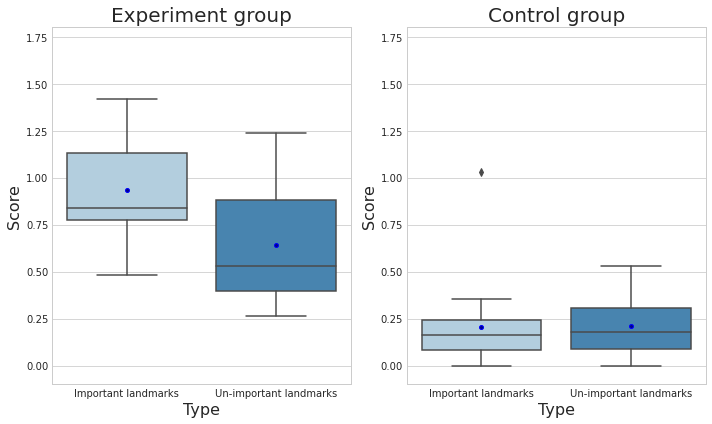

In [13]:
avg_frame_ex.index = avg_frame_ex.index.map(lambda x: str(int(x)) + "_EX")
avg_frame_co.index = avg_frame_co.index.map(lambda x: str(int(x)) + "_CO")
avg_frame_ex = avg_frame_ex.T
avg_frame_co = avg_frame_co.T

# 绘制箱线图
plt.figure(figsize=(10, 6))

# 绘制 frame1 的箱线图
plt.subplot(1, 2, 1)
meanprops = dict(marker='o', markerfacecolor='blue', markersize=4)

# avg_frame_ex_.boxplot(meanprops = meanprops, medianprops = {'lw': 2, 'ls': '-'})
meanprops = dict(marker='o', markersize=4, markeredgecolor='blue', markerfacecolor='darkblue')
sns.boxplot(data = avg_frame_ex, palette="Blues", meanprops = meanprops, showmeans=True)

plt.ylim(-0.1, 1.8)
plt.title("Experiment group", fontsize=20)
plt.ylabel("Score", fontsize=16)
plt.xlabel("Type", fontsize=16)
new_labels = ["Important landmarks", "Un-important landmarks"]
plt.xticks(range(len(new_labels)), new_labels)
# 绘制 frame2 的箱线图
plt.subplot(1, 2, 2)
#avg_frame_co_.boxplot()
sns.boxplot(data = avg_frame_co, palette="Blues", meanprops = meanprops, showmeans=True)
plt.ylim(-0.1, 1.8)
plt.title("Control group",  fontsize=20)
plt.ylabel("Score", fontsize=16)
plt.xlabel("Type", fontsize=16)
new_labels = ["Important landmarks", "Un-important landmarks"]
plt.xticks(range(len(new_labels)), new_labels)
plt.tight_layout()
plt.savefig("diffbox_socre.png")

plt.show()

In [14]:
diff_analysis(avg_frame_ex["0_EX"].tolist(), avg_frame_ex["1_EX"].tolist())
diff_analysis(avg_frame_co["0_CO"].tolist(), avg_frame_co["1_CO"].tolist())
diff_analysis(avg_frame_co["0_CO"].tolist(), avg_frame_ex["0_EX"].tolist())
diff_analysis(avg_frame_co["1_CO"].tolist(), avg_frame_ex["1_EX"].tolist())

Levene's test statistic for variance comparison: 0.48661744233595355
P-value for variance comparison: 0.4899211682554143
The statistical value of t test is STA: 3.20192295047195 and p_value: 0.00285244333470006
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.
Levene's test statistic for variance comparison: 0.23312343404786526
P-value for variance comparison: 0.6321407399919718
The statistical value of t test is STA: -0.13670932883326545 and p_value: 0.8920222441526229
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.
Levene's test statistic for variance comparison: 1.5430393198724768
P-value for variance comparison: 0.22219746909880084
The statistical value of t test is STA: -9.249662155992509 and p_value: 4.784099547310126e-11
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.
Levene's test statist

BLOCK  1
Levene's test statistic for variance comparison: 1.666509211147851
P-value for variance comparison: 0.2049555744646228
The statistical value of t test is STA: -10.409161099824097 and p_value: 2.1050054396983305e-12
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.
Levene's test statistic for variance comparison: 5.6053811659192805
P-value for variance comparison: 0.023399421405755245
The statistical value of t test is STA: 76.5 and p_value: 0.0006627582287987981
Reject the null hypothesis using Mann-Whitney U's t-test: There is a significant difference between the two vectors.


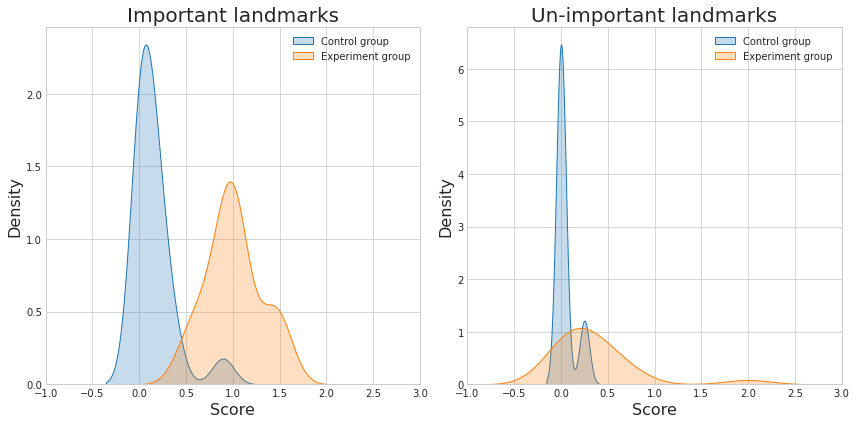

BLOCK  2
Levene's test statistic for variance comparison: 1.0228648285137876
P-value for variance comparison: 0.31859003964161275
The statistical value of t test is STA: -3.0993003565387194 and p_value: 0.0037535103041232945
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.
Levene's test statistic for variance comparison: 0.11593059936908567
P-value for variance comparison: 0.7354696509039882
The statistical value of t test is STA: -4.841616802650493 and p_value: 2.435360000544553e-05
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.


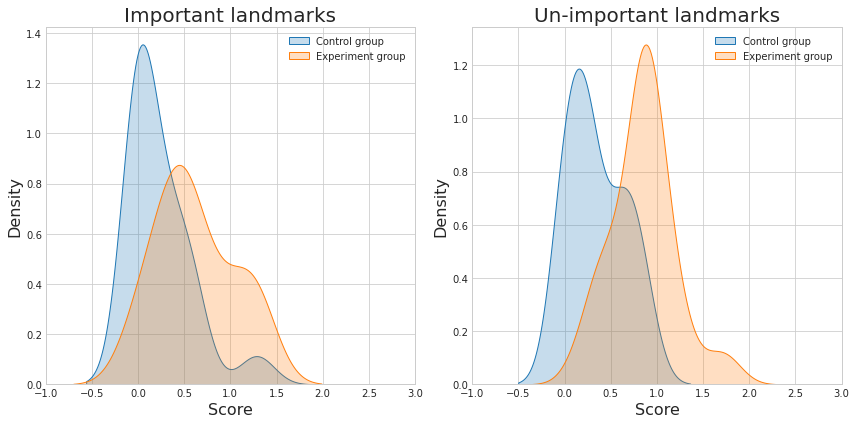

BLOCK  3
Levene's test statistic for variance comparison: 1.7068965517241383
P-value for variance comparison: 0.19967404195853983
The statistical value of t test is STA: -4.653076982162368 and p_value: 4.315110899755415e-05
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.
Levene's test statistic for variance comparison: 4.577240940877304
P-value for variance comparison: 0.03925134625042281
The statistical value of t test is STA: 76.5 and p_value: 0.0014104297449996435
Reject the null hypothesis using Mann-Whitney U's t-test: There is a significant difference between the two vectors.


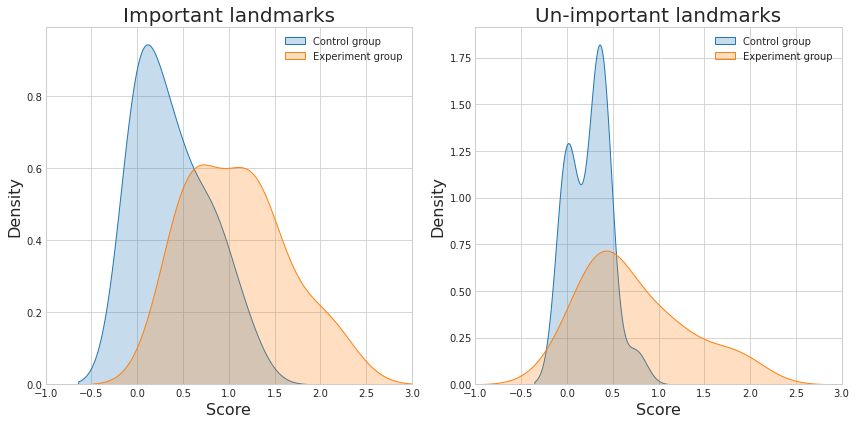

0.002821749790379056
0.004848804092081173
0.08889760036642963
0.00033468887098962394


In [15]:
def perform_anova(*data_arrays):
    f_statistic, p_value = f_oneway(*data_arrays)
    return p_value
e_1 = []
e_2 = []
c_1 = []
c_2 = []
for idx, (df_c, df_e) in enumerate(zip(dataframes_co, dataframes_ex)):
    grouped_c = df_c.groupby("TYPE")
    grouped_e = df_e.groupby("TYPE")
    # 提取列名为 "1~12" 的列
    columns_to_average = [str(i) for i in range(1, 20)]
    print("BLOCK ", idx + 1)
    # 计算每个分组中 "1~12" 列的平均值
    averages_e = grouped_e[columns_to_average].mean()
    averages_c = grouped_c[columns_to_average].mean()
    row_list_e_1 = averages_e.iloc[0].tolist()
    row_list_e_2 = averages_e.iloc[1].tolist()
    row_list_c_1 = averages_c.iloc[0].tolist()
    row_list_c_2 = averages_c.iloc[1].tolist()
    e_1.append(row_list_e_1)
    e_2.append(row_list_e_2)
    c_1.append(row_list_c_1)
    c_2.append(row_list_c_2)
    draw_kde_BLOCK(row_list_c_1, row_list_e_1, row_list_c_2, row_list_e_2, "quant_block" + str(idx + 1))
print(perform_anova(e_1[0], e_1[1], e_1[2]))
print(perform_anova(e_2[0], e_2[1], e_2[2]))
print(perform_anova(c_1[0], c_1[1], c_1[2]))
print(perform_anova(c_2[0], c_2[1], c_2[2]))

## Edit distance

In [16]:
co_edit_json = None
ex_edit_json = None
with open('./CO/editDis.json', 'r') as json_file:
    co_edit_json = json.load(json_file)
with open('./EX/editDis.json', 'r') as json_file:
    ex_edit_json = json.load(json_file)
standard_structure = co_edit_json["standard"]
del co_edit_json["standard"]
del ex_edit_json["standard"]
keys = ["1-1", "1-2", "2-1", "2-2", "3-1", "3-2"]
co_edit_score = []
ex_edit_score = []

for item in co_edit_json:
    tmp_arr = []
    item = co_edit_json[item]
    for key in keys:
        tmp_arr.append(Levenshtein.distance(item[key], standard_structure[key]))
    n_tmp_arr = [(tmp_arr[0] + tmp_arr[1])/(len(standard_structure["1-1"]) + len(standard_structure["1-2"])), 
                 (tmp_arr[2] + tmp_arr[3])/(len(standard_structure["2-1"]) + len(standard_structure["2-2"])), 
                 (tmp_arr[4] + tmp_arr[5])/(len(standard_structure["3-1"]) + len(standard_structure["3-2"]))]
    co_edit_score.append(n_tmp_arr)
for item in ex_edit_json:
    tmp_arr = []
    item = ex_edit_json[item]
    for key in keys:
        tmp_arr.append(Levenshtein.distance(item[key], standard_structure[key]))
    n_tmp_arr = [(tmp_arr[0] + tmp_arr[1])/(len(standard_structure["1-1"]) + len(standard_structure["1-2"])), 
                 (tmp_arr[2] + tmp_arr[3])/(len(standard_structure["2-1"]) + len(standard_structure["2-2"])), 
                 (tmp_arr[4] + tmp_arr[5])/(len(standard_structure["3-1"]) + len(standard_structure["3-2"]))]
    ex_edit_score.append(n_tmp_arr)
print(np.mean(np.array(co_edit_score)), np.mean(np.array(ex_edit_score)))
overall_co_edit_score = [np.mean(item) for item in co_edit_score]
overall_ex_edit_score = [np.mean(item) for item in ex_edit_score]

0.9268954022774056 0.6904585699152762


Levene's test statistic for variance comparison: 4.279293337232386
P-value for variance comparison: 0.04581916145668249
The statistical value of t test is STA: 346.5 and p_value: 1.3499218028609491e-06
Reject the null hypothesis using Mann-Whitney U's t-test: There is a significant difference between the two vectors.
19 19


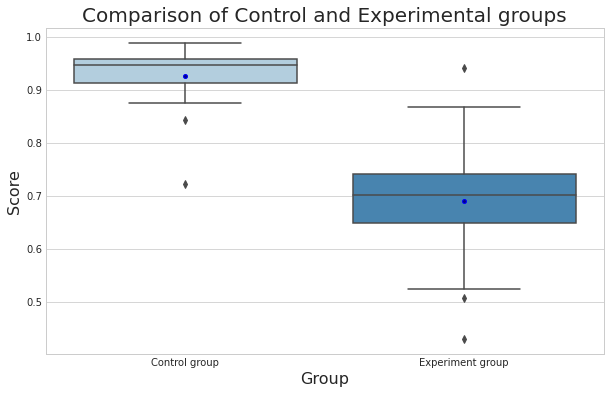

In [17]:
diff_analysis(overall_co_edit_score, overall_ex_edit_score)
print(len(overall_co_edit_score), len(overall_ex_edit_score))
df = pd.DataFrame({'Control group': overall_co_edit_score, 'Experiment group': overall_ex_edit_score})

plt.figure(figsize=(10, 6))
meanprops = dict(marker='o', markersize=4, markeredgecolor='blue', markerfacecolor='darkblue')
# df.boxplot(color=colors, meanprops = meanprops, showmeans=True, patch_artist=True)
sns.boxplot(data = df, palette="Blues", meanprops = meanprops, showmeans=True)
plt.xlabel('Group', fontsize = 16)
plt.ylabel('Score', fontsize = 16)
plt.title('Comparison of Control and Experimental groups', fontsize = 20)
plt.savefig("diffbox_edit.png")
plt.show()

BLOCK 1
CO:  0.910931174089069 , EX:  0.6761133603238867
Levene's test statistic for variance comparison: 5.553846153846159
P-value for variance comparison: 0.02400061978284043
The statistical value of t test is STA: 312.0 and p_value: 9.746524199320076e-05
Reject the null hypothesis using Mann-Whitney U's t-test: There is a significant difference between the two vectors.


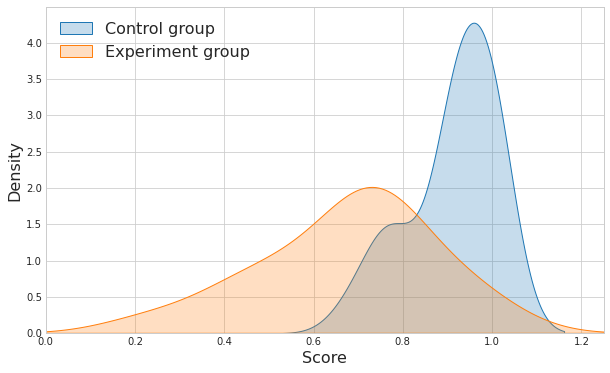



BLOCK 2
CO:  0.9524617996604414 , EX:  0.6910016977928691
Levene's test statistic for variance comparison: 6.9501396090945295
P-value for variance comparison: 0.012290921297637274
The statistical value of t test is STA: 347.0 and p_value: 1.0824214730771063e-06
Reject the null hypothesis using Mann-Whitney U's t-test: There is a significant difference between the two vectors.


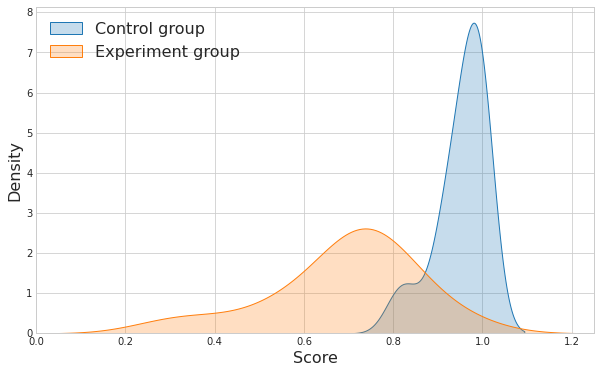



BLOCK 3
CO:  0.9172932330827068 , EX:  0.7042606516290725
Levene's test statistic for variance comparison: 0.24827586206896626
P-value for variance comparison: 0.6213223549201938
The statistical value of t test is STA: 7.178116506219599 and p_value: 1.9195497718653795e-08
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.


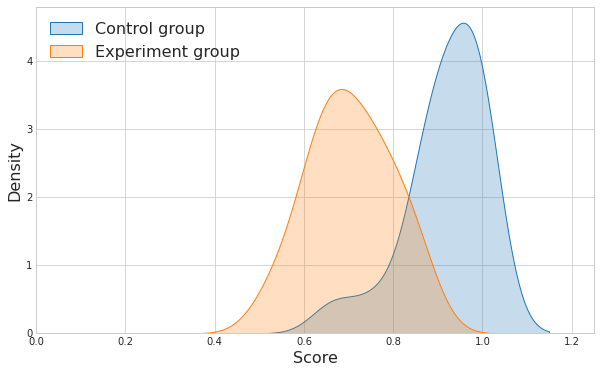



0.8575046952529292
0.25861711895082823


In [18]:
e_e = []
e_c = []
for i in range(3):
    array_c = [item[i] for item in co_edit_score]
    array_e = [item[i] for item in ex_edit_score]
    print("BLOCK " + str(i + 1))
    print("CO: ", np.mean(array_c), ", EX: ", np.mean(array_e))
    diff_analysis(array_c, array_e)
    # 绘制两组数据的核密度估计图
    e_e.append(array_e)
    e_c.append(array_c)
    plt.figure(figsize=(10, 6))
    sns.kdeplot(array_c, label='Control group', fill=True)
    sns.kdeplot(array_e, label='Experiment group', fill=True)
    plt.xlabel('Score', fontsize = 16)
    plt.ylabel('Density', fontsize = 16)
    # plt.title('Kernel Density Estimate of Two Data Sets')
    plt.legend(fontsize = 16, loc='upper left')
    plt.xlim(0, 1.25)
    plt.savefig("edit_block" + str(i + 1) + ".png")
    plt.show()
    print("\n")
print(perform_anova(e_e[0], e_e[1], e_e[2]))
print(perform_anova(e_c[0], e_c[1], e_c[2]))

## POST ANLAYSIS

In [19]:
# Variable
COLORS_IDX = [3, 6, 9, 12]
LABELS_IDX = [4, 7, 10, 13]
LAND_IDX = [5, 8, 11, 14]
OVERALL_EVA_IDX = [16, 17, 18, 21]

In [20]:
ex_colors_eva = []
co_colors_eva = []

ex_labels_eva = []
co_labels_eva = []

ex_land_eva = []
co_land_eva = []

ex_overall_eva = []
co_overall_eva = []

for item in co_json_datas:
    color = 0
    label = 0
    land = 0
    overall = 0
    for idx in COLORS_IDX:
        color += item["post"][idx]
    color /= 4
    for idx in OVERALL_EVA_IDX:
        overall += item["post"][idx]
    overall /= 4
    for idx in LABELS_IDX:
        label += item["post"][idx]
    label /= 4
    for idx in LAND_IDX:
        land += item["post"][idx]
    land /= 4
    co_colors_eva.append(color)
    co_labels_eva.append(label)
    co_land_eva.append(land)
    co_overall_eva.append(overall)

for item in ex_json_datas:
    color = 0
    label = 0
    land = 0
    overall = 0
    for idx in COLORS_IDX:
        color += item["post"][idx]
    color /= 4
    for idx in OVERALL_EVA_IDX:
        overall += item["post"][idx]
    overall /= 4
    for idx in LABELS_IDX:
        label += item["post"][idx]
    label /= 4
    for idx in LAND_IDX:
        land += item["post"][idx]
    land /= 4
    ex_colors_eva.append(color)
    ex_labels_eva.append(label)
    ex_land_eva.append(land)
    ex_overall_eva.append(overall)

In [21]:
print("COLORS: ")
print(np.mean(ex_colors_eva), np.mean(co_colors_eva))
diff_analysis(ex_colors_eva, co_colors_eva)
ConhenD(ex_colors_eva, co_colors_eva)
print("\n")
print("LABELS: ")
print(np.mean(ex_labels_eva), np.mean(co_labels_eva))
diff_analysis(ex_labels_eva, co_labels_eva)
ConhenD(ex_labels_eva, co_labels_eva)
print("\n")
print("LANDMARKS: ")
print(np.mean(ex_land_eva), np.mean(co_land_eva))
diff_analysis(ex_land_eva, co_land_eva)
ConhenD(ex_land_eva, co_land_eva)
print("\n")
print("COLORS: ")
print(np.mean(ex_overall_eva), np.mean(co_overall_eva))
diff_analysis(ex_overall_eva, co_overall_eva)
ConhenD(ex_overall_eva, co_overall_eva)
print("\n")

COLORS: 
3.9342105263157894 3.789473684210526
Levene's test statistic for variance comparison: 0.7588532883642491
P-value for variance comparison: 0.3894599849883662
The statistical value of t test is STA: 0.28251602331563297 and p_value: 0.7791658834955507
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.
Cohen's d: 0.09166030158894725


LABELS: 
5.355263157894737 5.0131578947368425
Levene's test statistic for variance comparison: 0.17247987734764264
P-value for variance comparison: 0.6803821697982535
The statistical value of t test is STA: 0.8291306453862648 and p_value: 0.4124944595925035
Fail to reject the null hypothesis using Student's t-test: There is no significant difference between the two vectors.
Cohen's d: 0.26900550319525235


LANDMARKS: 
5.723684210526316 5.144736842105263
Levene's test statistic for variance comparison: 0.9521311475409828
P-value for variance comparison: 0.33568907796707037
The statist

### How do you like each element you saw

正态性检验结果:
COLOR: 0.22063420712947845
LABEL: 0.050161875784397125
LANDMARK: 0.011196968145668507

方差齐性检验结果:
Levene检验p值: 0.43288793632088296

多因素ANOVA结果:
ANOVA p值: 0.32514851114234017

各方面评分没有显著差异。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 Color    Label   0.4211 0.5394 -0.5313 1.3734  False
 Color Landmark   0.5789 0.3156 -0.3734 1.5313  False
 Label Landmark   0.1579 0.9159 -0.7944 1.1102  False
-----------------------------------------------------


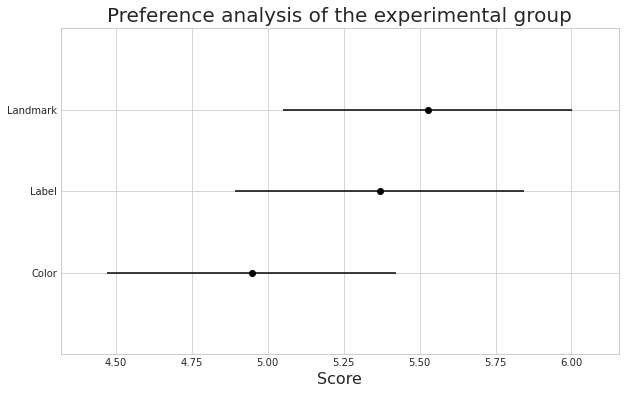

平均分数:
COLOR: 4.95
LABEL: 5.37
LANDMARK: 5.53

用户辅助最大的方面是：LANDMARK
正态性检验结果:
COLOR: 0.008323079906404018
LABEL: 0.0054520186968147755
LANDMARK: 0.008985137566924095

方差齐性检验结果:
Levene检验p值: 0.08122226496687407

多因素ANOVA结果:
ANOVA p值: 0.17507513213372772

各方面评分没有显著差异。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 Color    Label   0.9474 0.2031 -0.3717 2.2664  False
 Color Landmark   0.8421 0.2812  -0.477 2.1612  False
 Label Landmark  -0.1053 0.9798 -1.4243 1.2138  False
-----------------------------------------------------


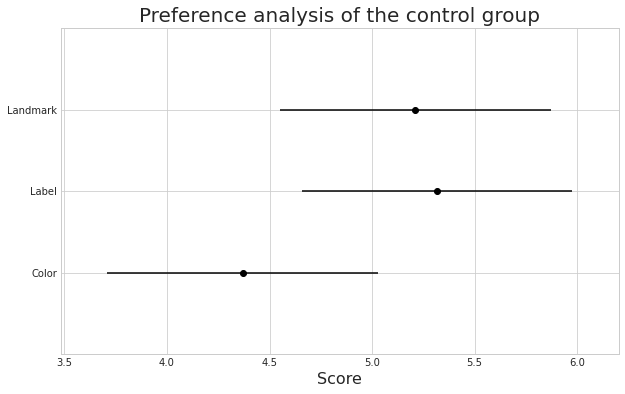

平均分数:
COLOR: 4.37
LABEL: 5.32
LANDMARK: 5.21

用户辅助最大的方面是：LABEL


In [22]:
EX_COLORS = []
EX_LABELS = []
EX_LANDMARKS = []
CO_COLORS = []
CO_LABELS = []
CO_LANDMARKS = []
for item in co_json_datas:
    CO_COLORS.append(item["post"][3])
    CO_LABELS.append(item["post"][4])
    CO_LANDMARKS.append(item["post"][5])
for item in ex_json_datas:
    EX_COLORS.append(item["post"][3])
    EX_LABELS.append(item["post"][4])
    EX_LANDMARKS.append(item["post"][5])
'''    
print("颜色方面：")
print(np.mean(EX_COLORS), np.mean(CO_COLORS))
diff_analysis(EX_COLORS, CO_COLORS)
ConhenD(EX_COLORS, CO_COLORS)
print("\n标签设计方面：")
print(np.mean(EX_LABELS), np.mean(CO_LABELS))
diff_analysis(EX_LABELS, CO_LABELS)
ConhenD(EX_LABELS, CO_LABELS)
print("\n地标设计方面：")
print(np.mean(EX_LANDMARKS), np.mean(CO_LANDMARKS))
diff_analysis(EX_LANDMARKS, CO_LANDMARKS)
ConhenD(EX_LANDMARKS, CO_LANDMARKS)
'''
n_array_variable_diff(EX_COLORS, EX_LABELS, EX_LANDMARKS, "Preference analysis of the experimental group", "PREF_EX.png")
n_array_variable_diff(CO_COLORS, CO_LABELS, CO_LANDMARKS, "Preference analysis of the control group", "PREF_CO.png")

### How do you think each element helps you remember the area

正态性检验结果:
COLOR: 0.12424939125776291
LABEL: 0.004233863670378923
LANDMARK: 0.0005033118650317192

方差齐性检验结果:
Levene检验p值: 0.08862281357434207

多因素ANOVA结果:
ANOVA p值: 3.306501575379985e-05

存在显著差异，可以进行事后分析。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 Color    Label   1.6316 0.0018  0.5498 2.7134   True
 Color Landmark   2.1579    0.0  1.0761 3.2397   True
 Label Landmark   0.5263 0.4746 -0.5555 1.6081  False
-----------------------------------------------------


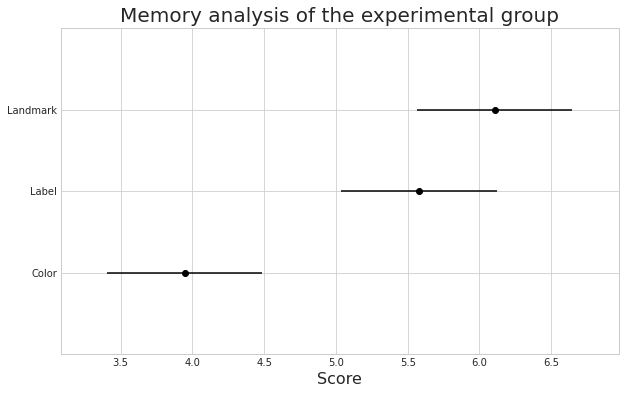

平均分数:
COLOR: 3.95
LABEL: 5.58
LANDMARK: 6.11

用户辅助最大的方面是：LANDMARK
正态性检验结果:
COLOR: 0.031188536435365677
LABEL: 0.12640339136123657
LANDMARK: 0.0015822940040379763

方差齐性检验结果:
Levene检验p值: 0.01640950685117929

多因素ANOVA结果:
ANOVA p值: 0.005330907601390646

存在显著差异，可以进行事后分析。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 Color    Label   1.5263 0.0197  0.2072 2.8454   True
 Color Landmark   1.6842 0.0091  0.3651 3.0033   True
 Label Landmark   0.1579 0.9552 -1.1612  1.477  False
-----------------------------------------------------


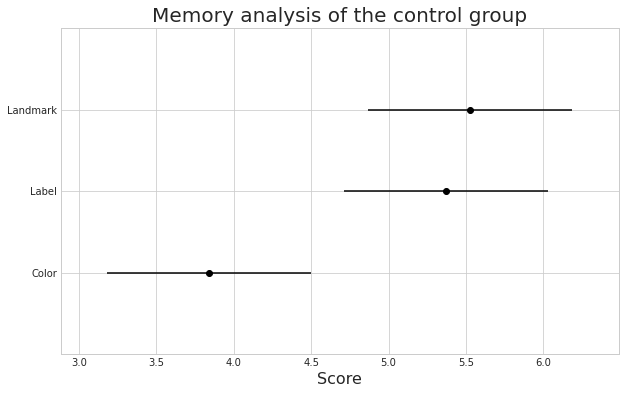

平均分数:
COLOR: 3.84
LABEL: 5.37
LANDMARK: 5.53

用户辅助最大的方面是：LANDMARK


In [23]:
EX_COLORS = []
EX_LABELS = []
EX_LANDMARKS = []
CO_COLORS = []
CO_LABELS = []
CO_LANDMARKS = []
for item in co_json_datas:
    CO_COLORS.append(item["post"][6])
    CO_LABELS.append(item["post"][7])
    CO_LANDMARKS.append(item["post"][8])
for item in ex_json_datas:
    EX_COLORS.append(item["post"][6])
    EX_LABELS.append(item["post"][7])
    EX_LANDMARKS.append(item["post"][8])

n_array_variable_diff(EX_COLORS, EX_LABELS, EX_LANDMARKS, "Memory analysis of the experimental group", "MEMORY_EX.png")
n_array_variable_diff(CO_COLORS, CO_LABELS, CO_LANDMARKS, "Memory analysis of the control group", "MEMORY_CO.png")

### How do you think each element helps you locate your position

正态性检验结果:
COLOR: 0.05189630761742592
LABEL: 0.0021106568165123463
LANDMARK: 0.0015014142263680696

方差齐性检验结果:
Levene检验p值: 0.22367583885672931

多因素ANOVA结果:
ANOVA p值: 1.5116050581277836e-06

存在显著差异，可以进行事后分析。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 Color    Label   2.0526 0.0002  0.9213  3.184   True
 Color Landmark   2.6316    0.0  1.5002 3.7629   True
 Label Landmark   0.5789  0.439 -0.5524 1.7103  False
-----------------------------------------------------


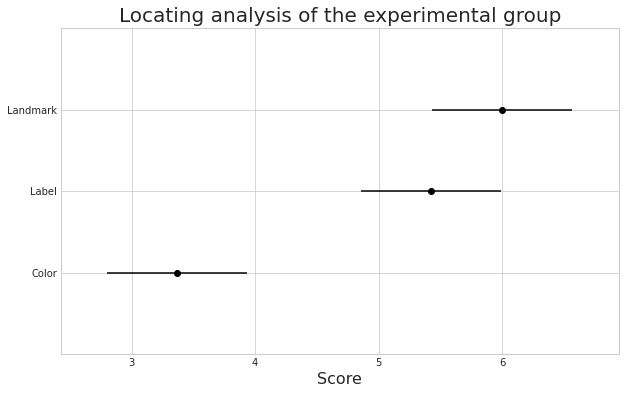

平均分数:
COLOR: 3.37
LABEL: 5.42
LANDMARK: 6.00

用户辅助最大的方面是：LANDMARK
正态性检验结果:
COLOR: 0.042429979890584946
LABEL: 0.1573743373155594
LANDMARK: 0.007807595189660788

方差齐性检验结果:
Levene检验p值: 0.714807713303458

多因素ANOVA结果:
ANOVA p值: 0.006705931630536125

存在显著差异，可以进行事后分析。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 Color    Label   1.2105 0.0806 -0.1167 2.5377  False
 Color Landmark   1.7895 0.0056  0.4623 3.1167   True
 Label Landmark   0.5789 0.5482 -0.7482 1.9061  False
-----------------------------------------------------


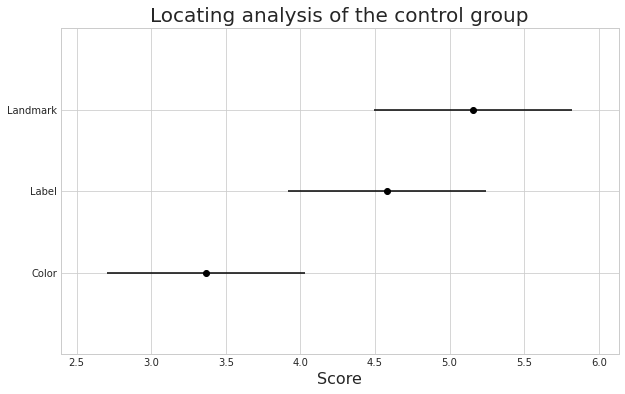

平均分数:
COLOR: 3.37
LABEL: 4.58
LANDMARK: 5.16

用户辅助最大的方面是：LANDMARK


In [24]:
EX_COLORS = []
EX_LABELS = []
EX_LANDMARKS = []
CO_COLORS = []
CO_LABELS = []
CO_LANDMARKS = []
for item in co_json_datas:
    CO_COLORS.append(item["post"][9])
    CO_LABELS.append(item["post"][10])
    CO_LANDMARKS.append(item["post"][11])
for item in ex_json_datas:
    EX_COLORS.append(item["post"][9])
    EX_LABELS.append(item["post"][10])
    EX_LANDMARKS.append(item["post"][11])

n_array_variable_diff(EX_COLORS, EX_LABELS, EX_LANDMARKS, "Locating analysis of the experimental group", "LOCATING_EX.png")
n_array_variable_diff(CO_COLORS, CO_LABELS, CO_LANDMARKS, "Locating analysis of the control group", "LOCATING_CO.png")

### How do you think each element helps you identify your orientation

正态性检验结果:
COLOR: 0.1407599151134491
LABEL: 0.014290203340351582
LANDMARK: 0.01020482461899519

方差齐性检验结果:
Levene检验p值: 0.8494701385263618

多因素ANOVA结果:
ANOVA p值: 0.005860749342512011

存在显著差异，可以进行事后分析。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 Color    Label   1.5789 0.0237  0.1779   2.98   True
 Color Landmark   1.7895  0.009  0.3885 3.1905   True
 Label Landmark   0.2105 0.9304 -1.1905 1.6115  False
-----------------------------------------------------


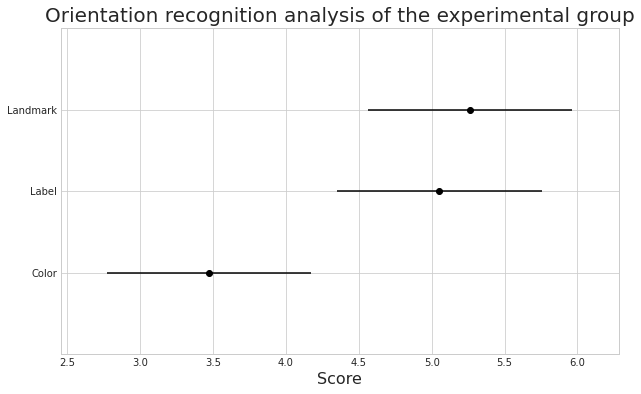

平均分数:
COLOR: 3.47
LABEL: 5.05
LANDMARK: 5.26

用户辅助最大的方面是：LANDMARK
正态性检验结果:
COLOR: 0.09565747529268265
LABEL: 0.031870219856500626
LANDMARK: 0.04568236321210861

方差齐性检验结果:
Levene检验p值: 0.9148801652576909

多因素ANOVA结果:
ANOVA p值: 0.13727086476186356

各方面评分没有显著差异。
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1  group2  meandiff p-adj   lower  upper  reject
-----------------------------------------------------
 Color    Label   1.2105 0.1688 -0.3816 2.8027  False
 Color Landmark   1.1053 0.2248 -0.4869 2.6974  False
 Label Landmark  -0.1053 0.9861 -1.6974 1.4869  False
-----------------------------------------------------


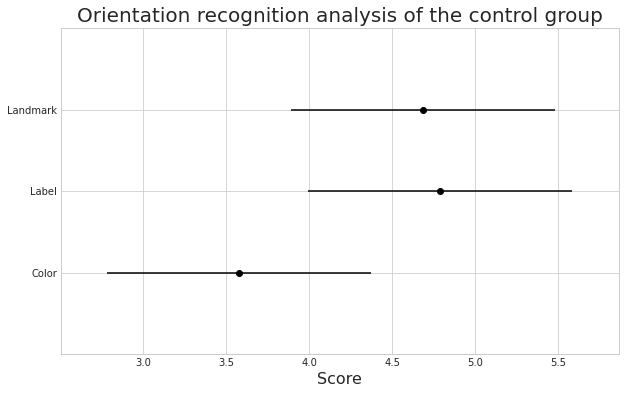

平均分数:
COLOR: 3.58
LABEL: 4.79
LANDMARK: 4.68

用户辅助最大的方面是：LABEL


In [25]:
EX_COLORS = []
EX_LABELS = []
EX_LANDMARKS = []
CO_COLORS = []
CO_LABELS = []
CO_LANDMARKS = []
for item in co_json_datas:
    CO_COLORS.append(item["post"][12])
    CO_LABELS.append(item["post"][13])
    CO_LANDMARKS.append(item["post"][14])
for item in ex_json_datas:
    EX_COLORS.append(item["post"][12])
    EX_LABELS.append(item["post"][13])
    EX_LANDMARKS.append(item["post"][14])

n_array_variable_diff(EX_COLORS, EX_LABELS, EX_LANDMARKS, "Orientation recognition analysis of the experimental group", "OREI_EX.png")
n_array_variable_diff(CO_COLORS, CO_LABELS, CO_LANDMARKS, "Orientation recognition analysis of the control group", "OREI_CO.png")

### COLORS

正态性检验结果:
喜好程度: 0.22063420712947845
辅助记忆区域: 0.12424939125776291
辅助定位: 0.05189630761742592
辅助认知朝向: 0.1407599151134491

方差齐性检验结果:
Levene检验p值: 0.4730099670671327

多因素ANOVA结果:
ANOVA p值: 0.02052794709033924

存在显著差异，可以进行事后分析。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.5789 0.7163 -0.8611  2.019  False
   LOCATING ORIENTATION   0.1053 0.9975 -1.3348 1.5453  False
   LOCATING  PREFERENCE   1.5789  0.026  0.1389  3.019   True
     MEMORY ORIENTATION  -0.4737 0.8227 -1.9137 0.9663  False
     MEMORY  PREFERENCE      1.0 0.2695   -0.44   2.44  False
ORIENTATION  PREFERENCE   1.4737 0.0429  0.0337 2.9137   True
-------------------------------------------------------------


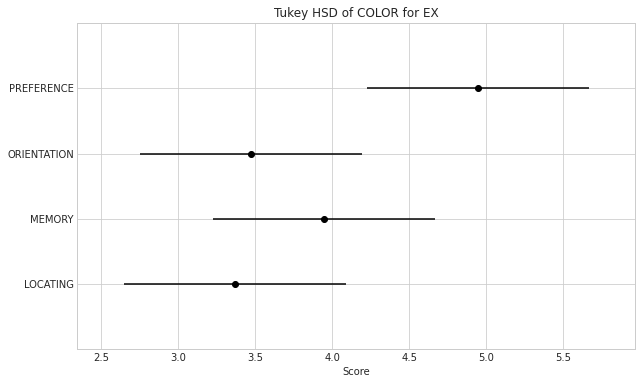

平均分数:
喜好程度: 4.95
辅助记忆区域: 3.95
辅助定位: 3.37
辅助认知朝向: 3.47

用户辅助最大的方面是：喜好程度
正态性检验结果:
喜好程度: 0.008323079906404018
辅助记忆区域: 0.031188536435365677
辅助定位: 0.042429979890584946
辅助认知朝向: 0.09565747529268265

方差齐性检验结果:
Levene检验p值: 0.8363805192870353

多因素ANOVA结果:
ANOVA p值: 0.47380451818316227

各方面评分没有显著差异。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.4737 0.8917 -1.2739 2.2213  False
   LOCATING ORIENTATION   0.2105 0.9889 -1.5371 1.9581  False
   LOCATING  PREFERENCE      1.0 0.4399 -0.7476 2.7476  False
     MEMORY ORIENTATION  -0.2632 0.9788 -2.0108 1.4844  False
     MEMORY  PREFERENCE   0.5263 0.8578 -1.2213 2.2739  False
ORIENTATION  PREFERENCE   0.7895 0.6363 -0.9581 2.5371  False
-------------------------------------------------------------


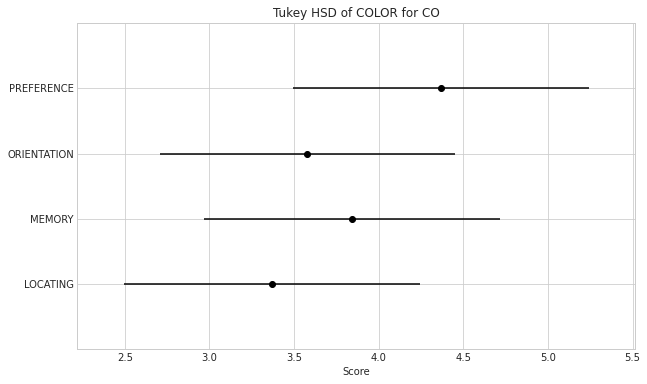

平均分数:
喜好程度: 4.37
辅助记忆区域: 3.84
辅助定位: 3.37
辅助认知朝向: 3.58

用户辅助最大的方面是：喜好程度


In [26]:
EX_LIKE = []
EX_REMEMBER = []
EX_LOCATION = []
EX_ORIENTATION = []
CO_LIKE = []
CO_REMEMBER = []
CO_LOCATION = []
CO_ORIENTATION = []
for item in co_json_datas:
    CO_LIKE.append(item["post"][3])
    CO_REMEMBER.append(item["post"][6])
    CO_LOCATION.append(item["post"][9])
    CO_ORIENTATION.append(item["post"][12])
for item in ex_json_datas:
    EX_LIKE.append(item["post"][3])
    EX_REMEMBER.append(item["post"][6])
    EX_LOCATION.append(item["post"][9])
    EX_ORIENTATION.append(item["post"][12])



array_variable_diff(EX_LIKE, EX_REMEMBER, EX_LOCATION, EX_ORIENTATION, "Tukey HSD of COLOR for EX")
array_variable_diff(CO_LIKE, CO_REMEMBER, CO_LOCATION, CO_ORIENTATION, "Tukey HSD of COLOR for CO")

### LABELS

正态性检验结果:
喜好程度: 0.050161875784397125
辅助记忆区域: 0.004233863670378923
辅助定位: 0.0021106568165123463
辅助认知朝向: 0.014290203340351582

方差齐性检验结果:
Levene检验p值: 0.7984460682732908

多因素ANOVA结果:
ANOVA p值: 0.756880812814815

各方面评分没有显著差异。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.1579 0.9888  -1.148 1.4638  False
   LOCATING ORIENTATION  -0.3684 0.8798 -1.6743 0.9375  False
   LOCATING  PREFERENCE  -0.0526 0.9996 -1.3585 1.2533  False
     MEMORY ORIENTATION  -0.5263 0.7148 -1.8322 0.7796  False
     MEMORY  PREFERENCE  -0.2105 0.9742 -1.5164 1.0954  False
ORIENTATION  PREFERENCE   0.3158   0.92 -0.9901 1.6217  False
-------------------------------------------------------------


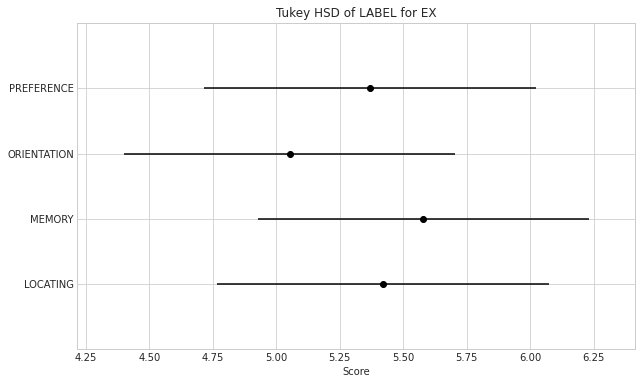

平均分数:
喜好程度: 5.37
辅助记忆区域: 5.58
辅助定位: 5.42
辅助认知朝向: 5.05

用户辅助最大的方面是：辅助记忆区域
正态性检验结果:
喜好程度: 0.0054520186968147755
辅助记忆区域: 0.12640339136123657
辅助定位: 0.1573743373155594
辅助认知朝向: 0.031870219856500626

方差齐性检验结果:
Levene检验p值: 0.10995638024096913

多因素ANOVA结果:
ANOVA p值: 0.33330317841561247

各方面评分没有显著差异。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.7895 0.4207 -0.5609 2.1398  False
   LOCATING ORIENTATION   0.2105 0.9766 -1.1398 1.5609  False
   LOCATING  PREFERENCE   0.7368 0.4819 -0.6135 2.0872  False
     MEMORY ORIENTATION  -0.5789 0.6738 -1.9293 0.7714  False
     MEMORY  PREFERENCE  -0.0526 0.9996  -1.403 1.2977  False
ORIENTATION  PREFERENCE   0.5263 0.7354 -0.8241 1.8767  False
-------------------------------------------------------------


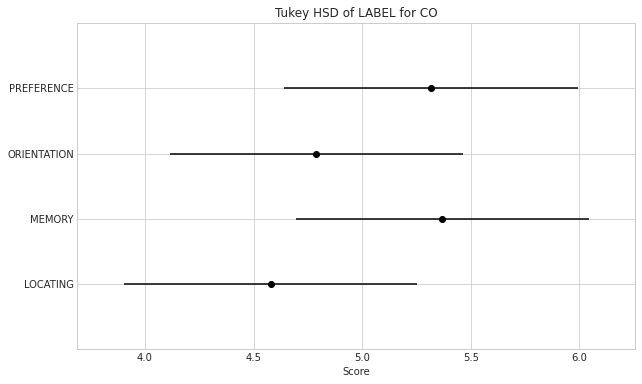

平均分数:
喜好程度: 5.32
辅助记忆区域: 5.37
辅助定位: 4.58
辅助认知朝向: 4.79

用户辅助最大的方面是：辅助记忆区域


In [27]:
EX_LIKE = []
EX_REMEMBER = []
EX_LOCATION = []
EX_ORIENTATION = []
CO_LIKE = []
CO_REMEMBER = []
CO_LOCATION = []
CO_ORIENTATION = []
for item in co_json_datas:
    CO_LIKE.append(item["post"][4])
    CO_REMEMBER.append(item["post"][7])
    CO_LOCATION.append(item["post"][10])
    CO_ORIENTATION.append(item["post"][13])
for item in ex_json_datas:
    EX_LIKE.append(item["post"][4])
    EX_REMEMBER.append(item["post"][7])
    EX_LOCATION.append(item["post"][10])
    EX_ORIENTATION.append(item["post"][13])



array_variable_diff(EX_LIKE, EX_REMEMBER, EX_LOCATION, EX_ORIENTATION, "Tukey HSD of LABEL for EX")
array_variable_diff(CO_LIKE, CO_REMEMBER, CO_LOCATION, CO_ORIENTATION, "Tukey HSD of LABEL for CO")

### LANDMARKS

正态性检验结果:
喜好程度: 0.011196968145668507
辅助记忆区域: 0.0005033118650317192
辅助定位: 0.0015014142263680696
辅助认知朝向: 0.01020482461899519

方差齐性检验结果:
Levene检验p值: 0.02379900018070013

多因素ANOVA结果:
ANOVA p值: 0.09070845907543663

各方面评分没有显著差异。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.1053 0.9922 -0.8811 1.0917  False
   LOCATING ORIENTATION  -0.7368  0.211 -1.7232 0.2495  False
   LOCATING  PREFERENCE  -0.4737 0.5892 -1.4601 0.5127  False
     MEMORY ORIENTATION  -0.8421 0.1209 -1.8285 0.1443  False
     MEMORY  PREFERENCE  -0.5789 0.4172 -1.5653 0.4074  False
ORIENTATION  PREFERENCE   0.2632 0.8961 -0.7232 1.2495  False
-------------------------------------------------------------


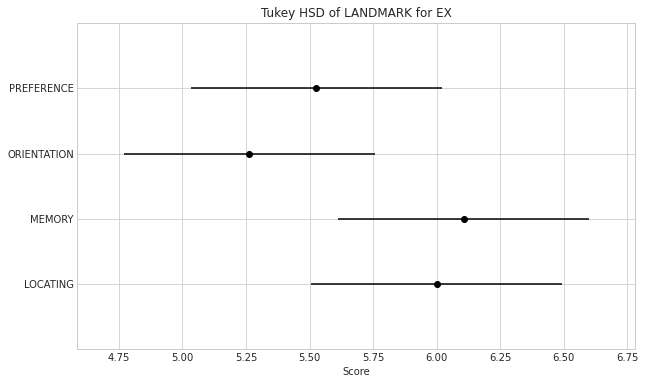

平均分数:
喜好程度: 5.53
辅助记忆区域: 6.11
辅助定位: 6.00
辅助认知朝向: 5.26

用户辅助最大的方面是：辅助记忆区域
正态性检验结果:
喜好程度: 0.008985137566924095
辅助记忆区域: 0.0015822940040379763
辅助定位: 0.007807595189660788
辅助认知朝向: 0.04568236321210861

方差齐性检验结果:
Levene检验p值: 0.45549450955635573

多因素ANOVA结果:
ANOVA p值: 0.49380499305078684

各方面评分没有显著差异。
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   LOCATING      MEMORY   0.3684 0.9067 -1.0698 1.8066  False
   LOCATING ORIENTATION  -0.4737 0.8222 -1.9119 0.9645  False
   LOCATING  PREFERENCE   0.0526 0.9997 -1.3855 1.4908  False
     MEMORY ORIENTATION  -0.8421 0.4193 -2.2803 0.5961  False
     MEMORY  PREFERENCE  -0.3158 0.9385  -1.754 1.1224  False
ORIENTATION  PREFERENCE   0.5263 0.7711 -0.9119 1.9645  False
-------------------------------------------------------------


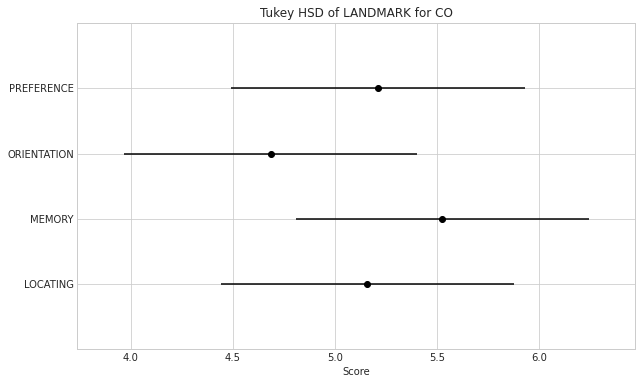

平均分数:
喜好程度: 5.21
辅助记忆区域: 5.53
辅助定位: 5.16
辅助认知朝向: 4.68

用户辅助最大的方面是：辅助记忆区域


In [28]:
EX_LIKE = []
EX_REMEMBER = []
EX_LOCATION = []
EX_ORIENTATION = []
CO_LIKE = []
CO_REMEMBER = []
CO_LOCATION = []
CO_ORIENTATION = []
for item in co_json_datas:
    CO_LIKE.append(item["post"][5])
    CO_REMEMBER.append(item["post"][8])
    CO_LOCATION.append(item["post"][11])
    CO_ORIENTATION.append(item["post"][14])
for item in ex_json_datas:
    EX_LIKE.append(item["post"][5])
    EX_REMEMBER.append(item["post"][8])
    EX_LOCATION.append(item["post"][11])
    EX_ORIENTATION.append(item["post"][14])



array_variable_diff(EX_LIKE, EX_REMEMBER, EX_LOCATION, EX_ORIENTATION, "Tukey HSD of LANDMARK for EX")
array_variable_diff(CO_LIKE, CO_REMEMBER, CO_LOCATION, CO_ORIENTATION, "Tukey HSD of LANDMARK for CO")

In [29]:
CO_MAP = []
CO_AR = []
EX_MAP = []
EX_AR = []
for item in co_json_datas:
    CO_MAP.append(item["post"][22])
    CO_AR.append(item["post"][23])
    
for item in ex_json_datas:
    EX_MAP.append(item["post"][22])
    EX_AR.append(item["post"][23])
print(np.mean(CO_MAP), np.mean(CO_AR))
diff_analysis(CO_MAP, CO_AR)
print("\n")
print(np.mean(EX_MAP), np.mean(EX_AR))
diff_analysis(EX_MAP, EX_AR)
print("\n")
diff_analysis(CO_AR, EX_AR)

4.105263157894737 5.578947368421052
Levene's test statistic for variance comparison: 3.83431952662722
P-value for variance comparison: 0.057997778210683866
The statistical value of t test is STA: -2.7754381219113755 and p_value: 0.008688969386491847
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.


4.526315789473684 5.631578947368421
Levene's test statistic for variance comparison: 3.0303030303030307
P-value for variance comparison: 0.09026475582160134
The statistical value of t test is STA: -2.457864091118742 and p_value: 0.0189230166395009
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.


Levene's test statistic for variance comparison: 0.3266129032258062
P-value for variance comparison: 0.5712115536515296
The statistical value of t test is STA: -0.13897231638362545 and p_value: 0.8902465536105595
Fail to reject the null hypothesis using Student's t-test: There 

In [30]:
ex_0_score = avg_frame_ex["0_EX"].to_list()
ex_1_score = avg_frame_ex["1_EX"].to_list()
co_0_score = avg_frame_co["0_CO"].to_list()
co_1_score = avg_frame_co["1_CO"].to_list()

[19, 19, 19, 19]


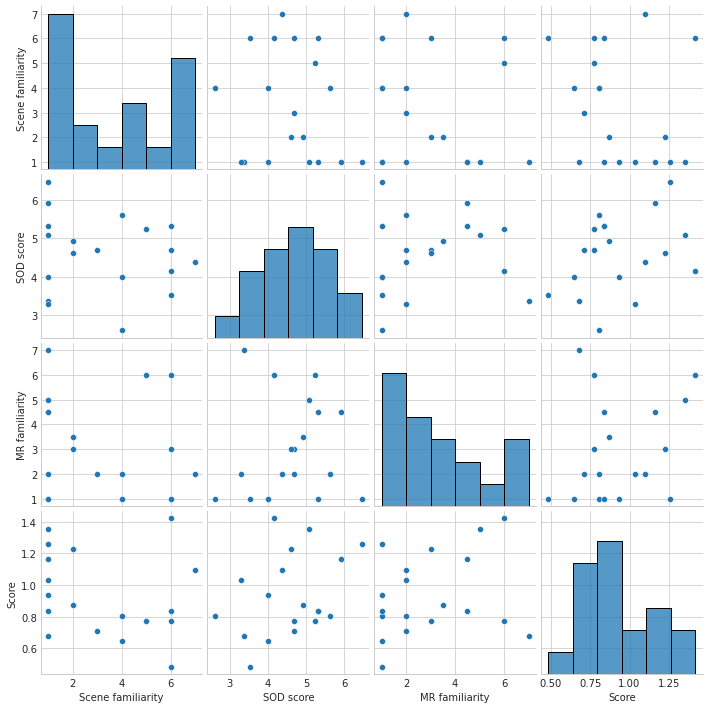

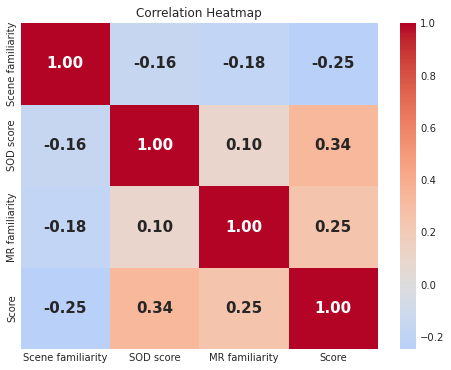

Linear Regression:
Mean Squared Error: 0.1992406903945659
R-squared: -3.5081301013017674

Polynomial Regression:
Mean Squared Error: 1.0390106914931827
R-squared: -22.50923079326236

Ridge Regression:
Mean Squared Error: 0.18845351784481137
R-squared: -3.264053566618113

Lasso Regression:
Mean Squared Error: 0.11234103205851372
R-squared: -1.5418903499649055

Decision Tree Regression:
Mean Squared Error: 0.13371488033298648
R-squared: -2.0255068672334864


In [31]:
print(list(map(lambda x: len(x), [ex_scene_familiar, average_sod_ex, ex_familiar_mr, ex_0_score])))
model_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, ex_0_score, "EX_0")

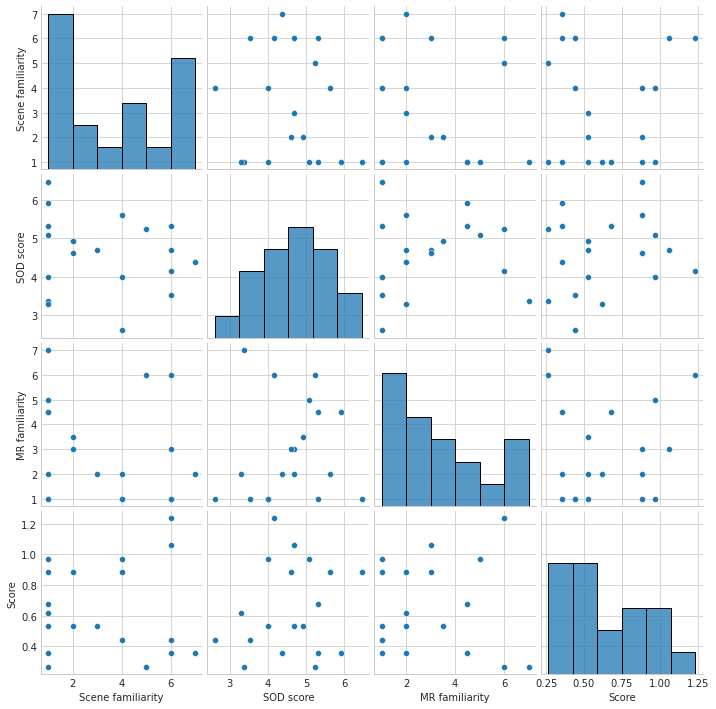

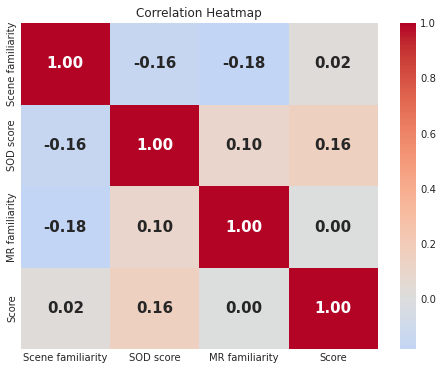

Linear Regression:
Mean Squared Error: 0.20520244228816695
R-squared: -2.5820909556478004

Polynomial Regression:
Mean Squared Error: 0.45617573773405057
R-squared: -6.963175126485004

Ridge Regression:
Mean Squared Error: 0.18401717330688874
R-squared: -2.2122729380618638

Lasso Regression:
Mean Squared Error: 0.0691671824231139
R-squared: -0.2074083320974447

Decision Tree Regression:
Mean Squared Error: 0.23543829296424446
R-squared: -3.1098993288590595


In [32]:
model_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, ex_1_score, "EX_1")

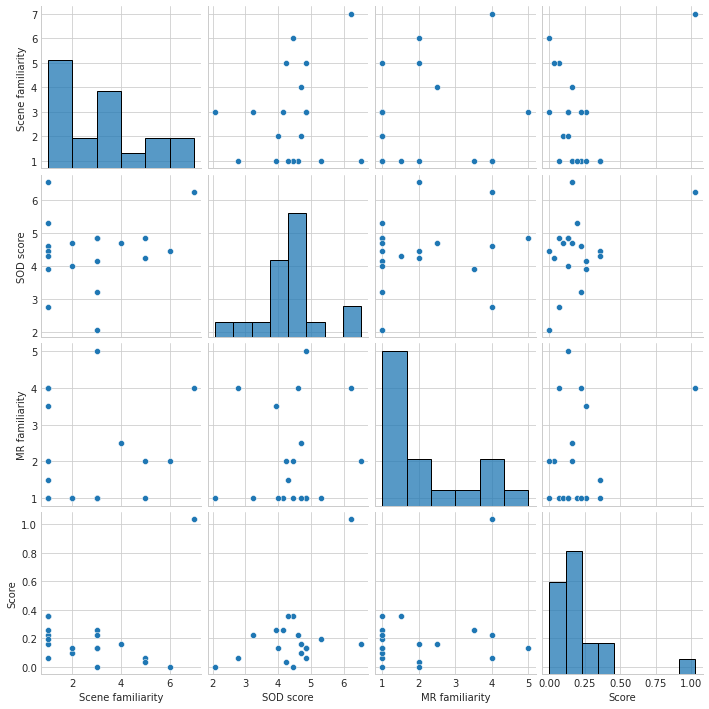

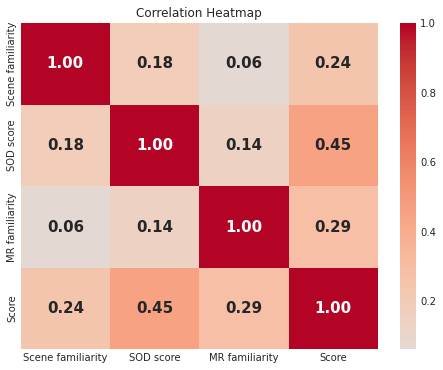

Linear Regression:
Mean Squared Error: 0.01940377594848599
R-squared: -3.1695219423218717

Polynomial Regression:
Mean Squared Error: 0.016667443106558363
R-squared: -2.581533302574492

Ridge Regression:
Mean Squared Error: 0.018628765731616714
R-squared: -3.002986206528024

Lasso Regression:
Mean Squared Error: 0.010528627940087848
R-squared: -1.2624124982315483

Decision Tree Regression:
Mean Squared Error: 0.031044051335414494
R-squared: -5.670807453416149


In [33]:
model_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, co_0_score, "CO_0")

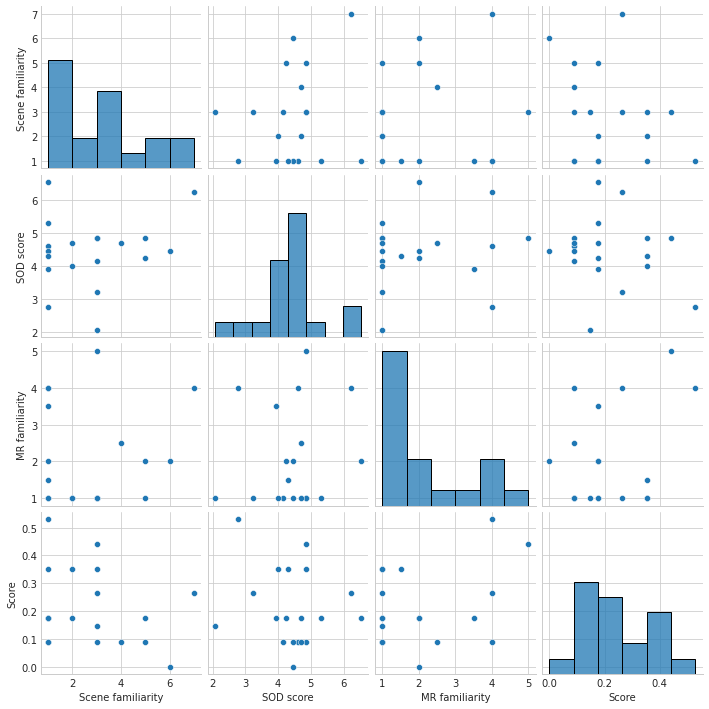

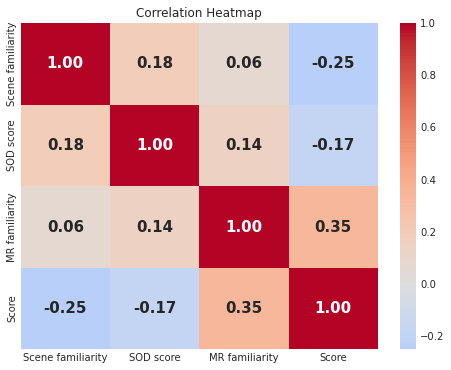

Linear Regression:
Mean Squared Error: 0.03961287866382572
R-squared: -7.72237861626334

Polynomial Regression:
Mean Squared Error: 0.07489347517888566
R-squared: -15.49082996319844

Ridge Regression:
Mean Squared Error: 0.03767443023877294
R-squared: -7.295550734480289

Lasso Regression:
Mean Squared Error: 0.018161006996647727
R-squared: -2.998880778690433

Decision Tree Regression:
Mean Squared Error: 0.07915224913494809
R-squared: -16.428571428571427


In [34]:
model_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, co_1_score, "CO_1")

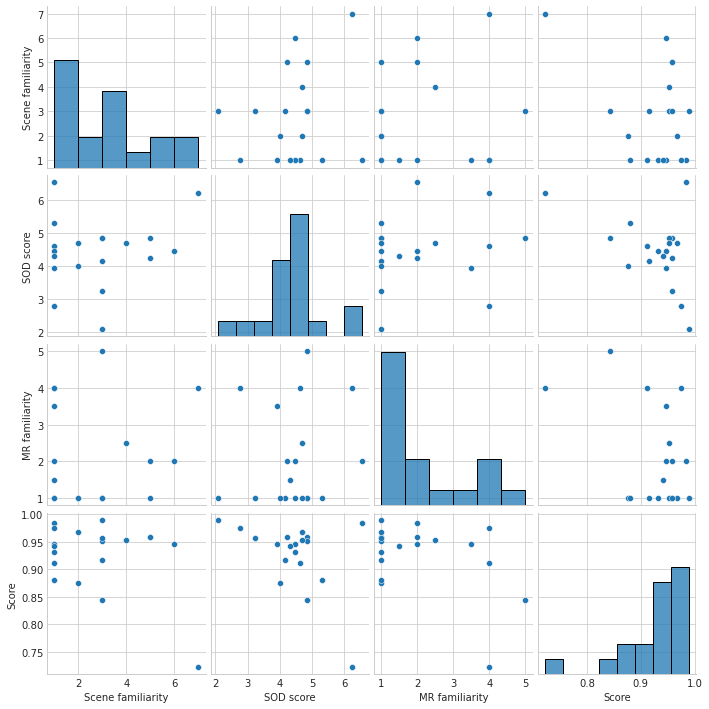

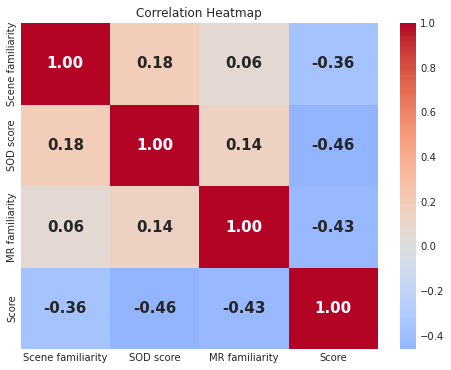

Linear Regression:
Mean Squared Error: 0.0012305284085574982
R-squared: -2.273552156645893

Polynomial Regression:
Mean Squared Error: 0.002325880744151534
R-squared: -5.187497885598503

Ridge Regression:
Mean Squared Error: 0.0012054866825274512
R-squared: -2.2069341121686494

Lasso Regression:
Mean Squared Error: 0.0007704481809266641
R-squared: -1.0496091652308555

Decision Tree Regression:
Mean Squared Error: 0.0014049891054029274
R-squared: -2.7376667487484734


In [35]:
model_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, overall_co_edit_score, "CO_edit")

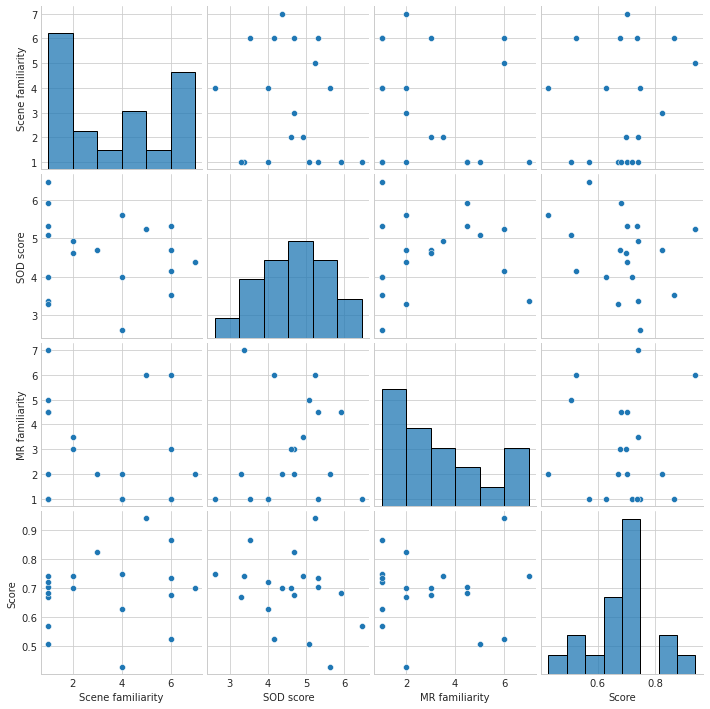

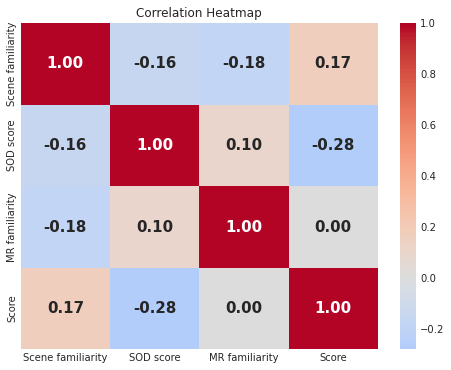

Linear Regression:
Mean Squared Error: 0.029544476456234824
R-squared: -0.7790583154901263

Polynomial Regression:
Mean Squared Error: 0.16993501858164842
R-squared: -9.23285379074134

Ridge Regression:
Mean Squared Error: 0.028219708001205653
R-squared: -0.6992856940490282

Lasso Regression:
Mean Squared Error: 0.018364137502131204
R-squared: -0.10581995177227133

Decision Tree Regression:
Mean Squared Error: 0.028709039831458876
R-squared: -0.7287514340473515


In [36]:
model_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, overall_ex_edit_score, "EX_edit")

In [37]:
corr_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, ex_0_score)

Spearman Correlation and p-value for scene familiarity: -0.2829993962938912 0.24038963556422874
Spearman Correlation and p-value for sod: 0.2994722955145118 0.21291873382132553
Spearman Correlation and p-value for mr familiarity: 0.21179731562415116 0.3840467098404833


In [38]:
corr_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, ex_1_score)

Spearman Correlation and p-value for scene familiarity: -0.03237153096543388 0.8953334714057912
Spearman Correlation and p-value for sod: 0.07294532355587945 0.7666416774551459
Spearman Correlation and p-value for mr familiarity: -0.01984883860522811 0.9357180606585197


In [39]:
corr_analysis(ex_scene_familiar, average_sod_ex, ex_familiar_mr, overall_ex_edit_score)

Spearman Correlation and p-value for scene familiarity: 0.17030075407928108 0.4857737074657944
Spearman Correlation and p-value for sod: -0.2784367809708199 0.24838137223073667
Spearman Correlation and p-value for mr familiarity: -0.05287961284037725 0.8297685775715163


In [40]:
corr_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, co_0_score)

Spearman Correlation and p-value for scene familiarity: -0.3464258570838459 0.14623411032652178
Spearman Correlation and p-value for sod: 0.1682864817369006 0.4910239872191866
Spearman Correlation and p-value for mr familiarity: 0.08977217658123145 0.7147519000170512


In [41]:
corr_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, co_1_score)

Spearman Correlation and p-value for scene familiarity: -0.22163001864259055 0.3618258148161456
Spearman Correlation and p-value for sod: -0.05922844745104368 0.8096677213872605
Spearman Correlation and p-value for mr familiarity: 0.19569057283372515 0.42203577474081033


In [42]:
corr_analysis(co_scene_familiar, average_sod_co, co_familiar_mr, overall_co_edit_score)

Spearman Correlation and p-value for scene familiarity: -0.020003157772500516 0.9352192820091568
Spearman Correlation and p-value for sod: -0.27100813478561386 0.26175013375593226
Spearman Correlation and p-value for mr familiarity: -0.20025637095777943 0.4110693527315521


## Fire extinguisher evaluation

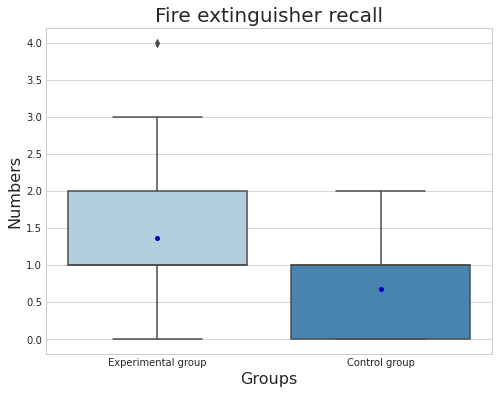

In [43]:
fire_co = [co_edit_json[item]["fire"] for item in co_edit_json]
fire_ex = [ex_edit_json[item]["fire"] for item in ex_edit_json]


# 使用Seaborn绘制箱线图
plt.figure(figsize=(8, 6))
df = pd.DataFrame({'Experimental group': fire_ex, 'Control group': fire_co})
meanprops = dict(marker='o', markersize=4, markeredgecolor='blue', markerfacecolor='darkblue')
sns.boxplot(data = df, palette="Blues", meanprops = meanprops, showmeans=True)

plt.title('Fire extinguisher recall', fontsize = 20)  # 添加标题
plt.xlabel('Groups', fontsize = 16)  # 添加x轴标签
plt.ylabel('Numbers', fontsize = 16)  # 添加y轴标签
plt.savefig("fire_ex_eva.png")
plt.show()

In [44]:
print(np.mean(fire_co), np.mean(fire_ex))
diff_analysis(fire_co, fire_ex)

0.6842105263157895 1.368421052631579
Levene's test statistic for variance comparison: 0.5062500000000003
P-value for variance comparison: 0.48135208562736587
The statistical value of t test is STA: -2.456769074559977 and p_value: 0.018972275724599783
Reject the null hypothesis using Student's t-test: There is a significant difference between the two vectors.
